# Testing In-Flight Detection Rate
This notebook looks at detecting GPS spoofing during flight. In the paper these
are Flights 1 through 5.

The data files can be found in the data subdirectory. Only interim data will be
available on github to preserve storage. For raw log files please contact me at
srimoungchanh.bailey@ku.edu.

## 1st Flight, 0.1m/s/s, 2.5m offset

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

import pandas as pd
import numpy as np
from confirmation.process import process_SNS
from os.path import exists

#Convert log file from Mission Planner to usable CSV
data_dir = "../data/"
file = "2023-01-30-Adv-250E-1cmss (1).log" #Change file for different log files
output = data_dir + "interim/" + file[:-3] + "csv"

#Check if file exists already and if it does skip processing and read the file
if not exists(output):
    #Open log file and parse out the SNS data into pandas dataframes
    df = process_SNS(data_dir + "raw/" + file, output, SNS_COUNT=5)
else:
    df = pd.read_csv(output)

#All of the data is numeric and should be treated as such
df = df.apply(pd.to_numeric)

#Set index to be the timestamps so we can drop duplicate rows
#then reset index to be row number
df.set_index("TimeUS",inplace=True)
df = df.drop_duplicates()
df.reset_index(inplace=True)

#Get rid of duplicate rows and convert timestamps to datetime
ofMS = df[df.ofMS.shift() != df.ofMS][["ofMS","frF","frR","brF","brR", "rf", "m00", "m10"]].reset_index()
ofMS['ofMS'] = pd.to_datetime(ofMS['ofMS'], unit='ms')
magUS = df[df.magUS.shift() != df.magUS][["magUS","magx","magy","magz"]].reset_index()
magUS['magUS'] = pd.to_datetime(magUS['magUS'], unit='us')
cUS = df[df.cUS.shift() != df.cUS][["cUS","gyrx","gyry","gyrz","CAN","CAE","CAD","rCAN","rCAE","rCAD", "CVN", "CVE", "CVD"]].reset_index()
cUS['cUS'] = pd.to_datetime(cUS['cUS'], unit='us')
gpsMS = df[df.gpsMS.shift() != df.gpsMS][["gpsMS","lat","lng","gpAlt", "m00", "m10"]].reset_index()
gpsMS['gpsMS'] = pd.to_datetime(gpsMS['gpsMS'], unit='ms')
rfMS = df[df.rfMS.shift() != df.rfMS][["rfMS","rf","m22"]].reset_index(drop=True)
rfMS['rfMS'] = pd.to_datetime(rfMS['rfMS'], unit='ms')

attack_start = pd.to_datetime(505851186, unit='us')
attack_end = pd.to_datetime(510531352, unit='us')
benign_dist = 7.348
benign_angle = 14
figure = 1

## Velocity

In [2]:
from confirmation.process import geodetic2ned, body_to_earth2D, low_pass_filter, signal_match_and_cumsum, change_in_signal, diff
import matplotlib.pyplot as plt
from matplotlib import dates
from scipy.integrate import trapezoid
plt.ion()
plt.rcParams.update({'font.size':12})

gps = geodetic2ned(gpsMS.lat, gpsMS.lng, gpsMS.gpAlt)
gps_north = (gps.North.diff().fillna(0)/(gpsMS.gpsMS.diff().dt.total_seconds()))[1:].reset_index(drop=True)
gps_east = (gps.East.diff().fillna(0)/(gpsMS.gpsMS.diff().dt.total_seconds()))[1:].reset_index(drop=True)
gps_down = (gps.Down.diff().fillna(0)/100/(gpsMS.gpsMS.diff().dt.total_seconds()))[1:].reset_index(drop=True)

#Convert optical flow and rangefinder to OF Velocity in body frame
of_vel_bf = pd.DataFrame(data={"OF Forward":(ofMS.frF - ofMS.brF) * ofMS.rf/100,
                               "OF Right":(ofMS.frR - ofMS.brR) * ofMS.rf/100})

earth_frame = body_to_earth2D(of_vel_bf["OF Forward"], of_vel_bf["OF Right"], ofMS.m00, ofMS.m10)

lpf_E = -low_pass_filter(earth_frame.East, alpha=0.2)
lpf_N = low_pass_filter(earth_frame.North, alpha=0.2)

gps_east = pd.Series(gps_east)
lpf_E = pd.Series(lpf_E)
gps_north = pd.Series(gps_north)
lpf_N = pd.Series(lpf_N)

#Matching OF to the GPS update rate
of_east = signal_match_and_cumsum(ofMS.ofMS[:-1].diff().dt.total_seconds().fillna(0).cumsum(), change_in_signal(lpf_E),
                                          gpsMS.gpsMS.diff().dt.total_seconds().fillna(0).cumsum(), gps_east)
of_east = pd.Series(of_east, name="OF East, LPF")
of_north = signal_match_and_cumsum(ofMS.ofMS[:-1].diff().dt.total_seconds().fillna(0).cumsum(), change_in_signal(lpf_N),
                                          gpsMS.gpsMS.diff().dt.total_seconds().fillna(0).cumsum(), gps_north)
of_north = pd.Series(of_north, name="OF North, LPF")

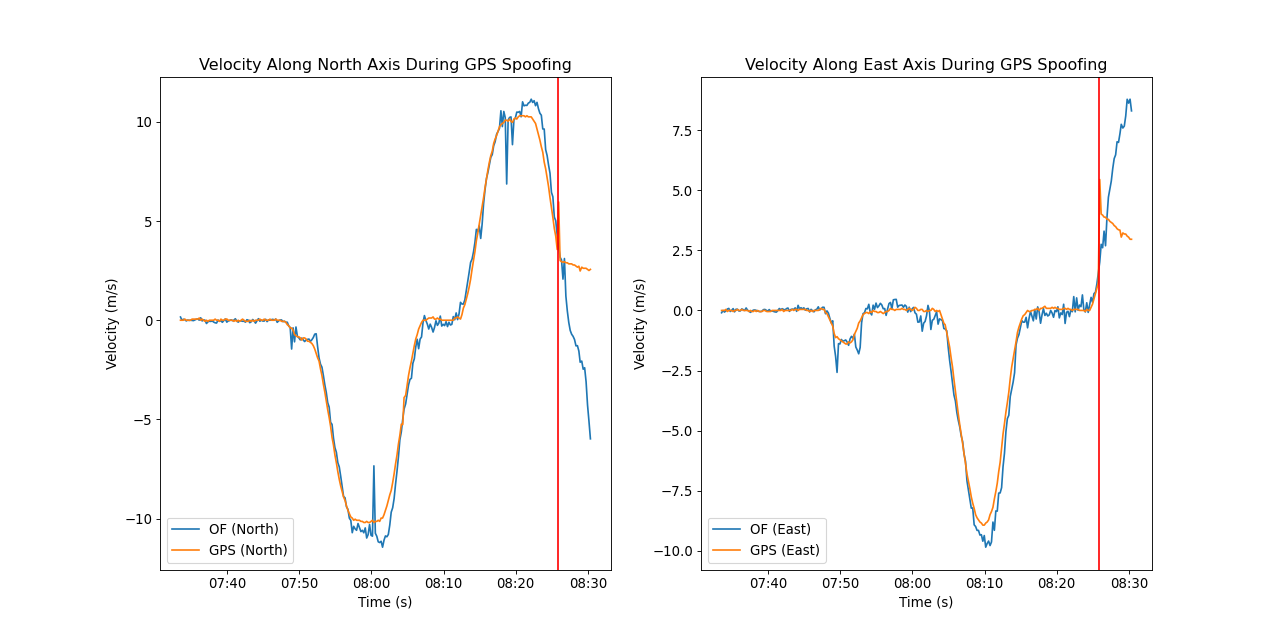

In [3]:
plt.figure(figure, figsize=(16, 8), dpi=80)
figure += 1
ax = plt.subplot(1, 2, 1)
plt1 = plt.plot(gpsMS.gpsMS[:(gpsMS.gpsMS < attack_end).sum()], of_north[:(gpsMS.gpsMS < attack_end).sum()]-of_north[1], label="OF (North)")
plt2 = plt.plot(gpsMS.gpsMS[:(gpsMS.gpsMS < attack_end).sum()], gps_north[:(gpsMS.gpsMS < attack_end).sum()], label="GPS (North)")
plt.axvline(attack_start, color='r')
plt.xlabel("Time (s)")
plt.ylabel("Velocity (m/s)")
plt.title("Velocity Along North Axis During GPS Spoofing")
ax.xaxis.set_major_formatter(dates.DateFormatter('%M:%S'))
plt.legend(loc='lower left')
ax = plt.subplot(1, 2, 2)
plt3 = plt.plot(gpsMS.gpsMS[:(gpsMS.gpsMS < attack_end).sum()], of_east[:(gpsMS.gpsMS < attack_end).sum()]-of_east[1], label="OF (East)")
plt4 = plt.plot(gpsMS.gpsMS[:(gpsMS.gpsMS < attack_end).sum()], gps_east[:(gpsMS.gpsMS < attack_end).sum()], label="GPS (East)")
plt.axvline(attack_start, color='r')
plt.xlabel("Time (s)")
plt.ylabel("Velocity (m/s)")
plt.title("Velocity Along East Axis During GPS Spoofing")
ax.xaxis.set_major_formatter(dates.DateFormatter('%M:%S'))
plt.legend(loc='lower left')
plt.show()

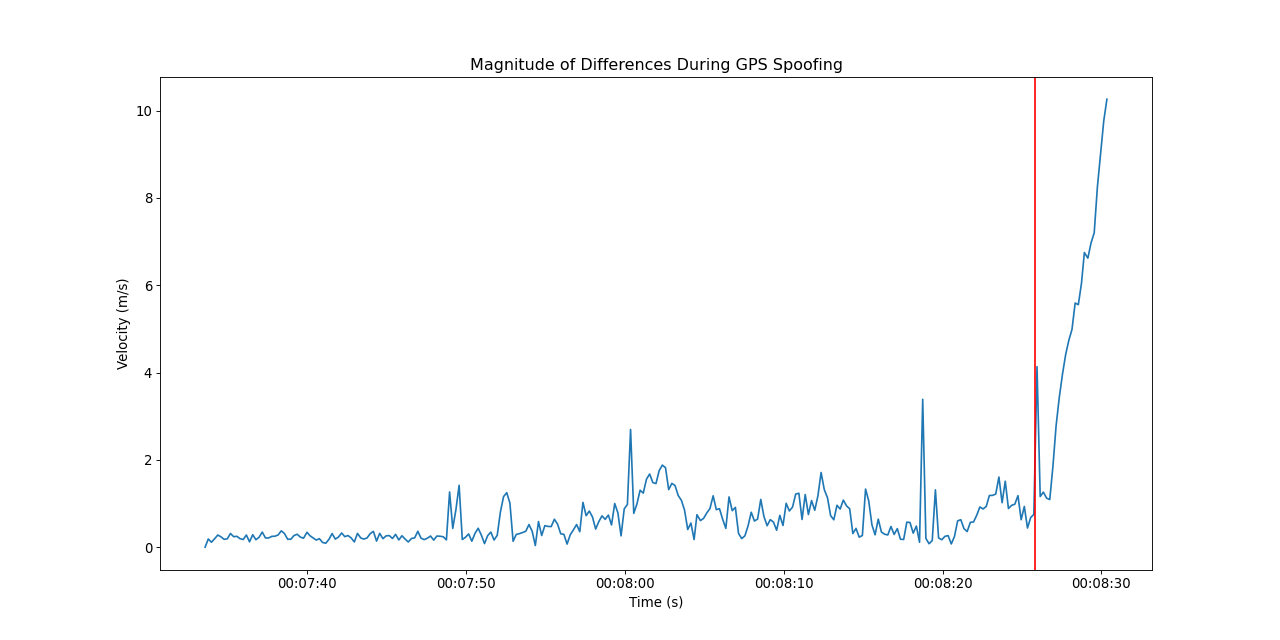

In [4]:
plt.figure(figure, figsize=(16, 8), dpi=80)
figure += 1
diff_east = abs((gps_east - of_east)[:(gpsMS.gpsMS < attack_end).sum()])
diff_north = abs((gps_north - of_north)[:(gpsMS.gpsMS < attack_end).sum()])
diffs = pd.Series([((x**2) + (y**2))**(1/2) for x,y in zip(diff_east, diff_north)])
plt.plot(gpsMS.gpsMS[:(gpsMS.gpsMS < attack_end).sum()],diffs)
plt.axvline(attack_start, color='r')
plt.xlabel("Time (s)")
plt.ylabel("Velocity (m/s)")
plt.title("Magnitude of Differences During GPS Spoofing")
ax.xaxis.set_major_formatter(dates.DateFormatter('%M:%S'))
plt.show()

In [5]:
print("Max difference between GPS and OF before attack is %f m/s and after attack is %f m/s" % (
       diffs[gpsMS.gpsMS < attack_start].max(),
       diffs[(gpsMS.gpsMS >= attack_start) & (gpsMS.gpsMS < attack_end)].max())
     )

Max difference between GPS and OF before attack is 3.387740 m/s and after attack is 10.262524 m/s


In [6]:
dt = (gpsMS.gpsMS[diffs[diffs>benign_dist].index[0]] - attack_start).total_seconds()
print("Time until detection: %fs" % dt)
dt = 0.70

Time until detection: 3.901814s


In [7]:
from confirmation.process import length
OF_Vel_East = of_east[(gpsMS.gpsMS >= attack_start) & (gpsMS.gpsMS < pd.Timestamp((attack_start.value/1000000000) + dt, unit='s'))]
OF_Vel_North = of_north[(gpsMS.gpsMS >= attack_start) & (gpsMS.gpsMS < pd.Timestamp((attack_start.value/1000000000) + dt, unit='s'))]
OF_Vel = length([OF_Vel_East.reset_index(drop=True), OF_Vel_North.reset_index(drop=True)])
OF_ts = gpsMS.gpsMS[(gpsMS.gpsMS >= attack_start) & (gpsMS.gpsMS < pd.Timestamp((attack_start.value/1000000000) + dt, unit='s'))]
print("Distance traveled until detection according to Optical Flow: %fm" % abs(trapezoid(y=OF_Vel, x=OF_ts.diff().dt.total_seconds().fillna(0).cumsum())))

Distance traveled until detection according to Optical Flow: 2.418620m


## GPS Ground Course and Gyroscope Yaw

In [8]:
#Read in data
df = pd.read_csv(output)

#All of the data is numeric and should be treated as such
df = df.apply(pd.to_numeric)

#Only want the aprt of the mission where the GPS is actually usable
df = df[df.TimeUS >= 470800000].reset_index(drop=True)

#Set index to be the timestamps so we can drop duplicate rows
#then reset index to be row number
df.set_index("TimeUS",inplace=True)
df = df.drop_duplicates()
df.reset_index(inplace=True)

#Get rid of duplicate rows and convert timestamps to datetime
cUS = df[df.cUS.shift() != df.cUS][["cUS","gyrx","gyry","gyrz","CAN","CAE","CAD","rCAN","rCAE","rCAD", "CVN", "CVE", "CVD"]].reset_index()
cUS['cUS'] = pd.to_datetime(cUS['cUS'], unit='us')
gpsMS = df[df.gpsMS.shift() != df.gpsMS][["gpsMS","lat","lng","gpAlt", "m00", "m10"]].reset_index()
gpsMS['gpsMS'] = pd.to_datetime(gpsMS['gpsMS'], unit='ms')

In [9]:
from confirmation.process import trap_integrate
from math import degrees, atan2
#GPS Velocity
gps = geodetic2ned(gpsMS.lat, gpsMS.lng, gpsMS.gpAlt)
gps_north = (gps.North.diff().fillna(0)/(gpsMS.gpsMS.diff().dt.total_seconds()))[1:].reset_index(drop=True)
gps_east = (gps.East.diff().fillna(0)/(gpsMS.gpsMS.diff().dt.total_seconds()))[1:].reset_index(drop=True)
gps_down = (gps.Down.diff().fillna(0)/100/(gpsMS.gpsMS.diff().dt.total_seconds()))[1:].reset_index(drop=True)

gps_east = pd.Series(gps_east)
gps_north = pd.Series(gps_north)

#GPS derived ground course
gps_gc = []
for reading in range(len(gps_north)):
    gps_gc.append(degrees(atan2(gps_east[reading], gps_north[reading])) % 360)
gps_gc = pd.Series(gps_gc, name="GPS Ground Course")

#Matching gyroscope to the GPS update rate
gyr_yaw = trap_integrate(cUS.cUS.diff().dt.total_seconds().fillna(0).cumsum(), cUS.gyrz).apply(degrees).cumsum() % 360
gyr_gps_yaw = signal_match_and_cumsum(cUS.cUS.diff().dt.total_seconds().fillna(0).cumsum(), change_in_signal(gyr_yaw),
                                          gpsMS.gpsMS.diff().dt.total_seconds().fillna(0).cumsum(), gps_gc)
gyr_gps_yaw = pd.Series(gyr_gps_yaw, name="Gyroscope Yaw")

#Start both signals at 0 to align them
gps_gc = (gps_gc - gps_gc[0] + 60) % 360
gyr_gps_yaw = (gyr_gps_yaw - gyr_gps_yaw[0] + 60)%360

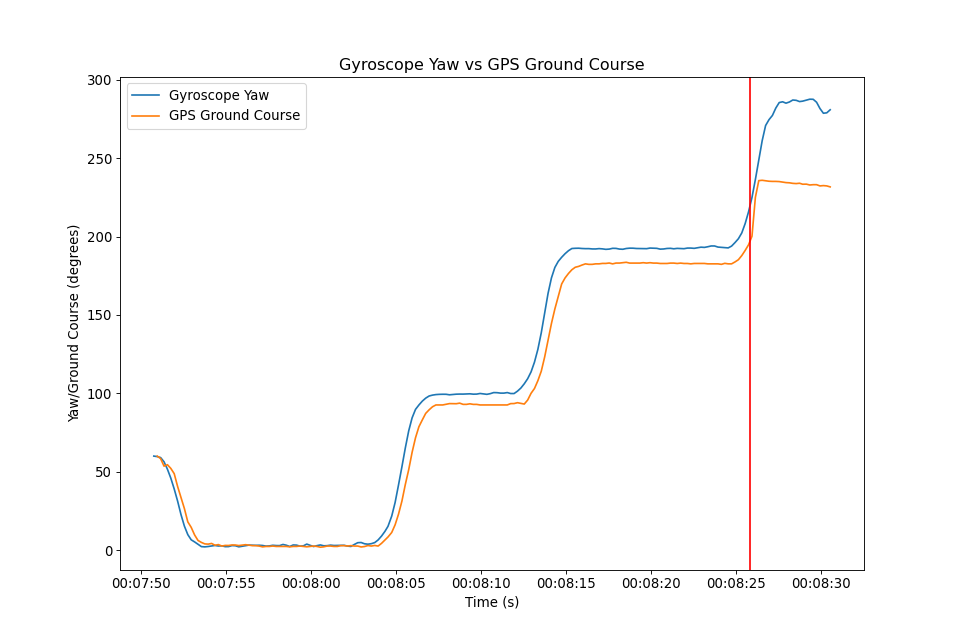

In [10]:
plt.figure(figure, figsize=(12, 8), dpi=80)
figure += 1
plt.subplot(1, 1, 1)
plt.plot(gpsMS.gpsMS[:-1], gyr_gps_yaw[:-1], label="Gyroscope Yaw")
plt.plot(gpsMS.gpsMS[1:-1], gps_gc[:-1], label="GPS Ground Course")
plt.xlabel("Time (s)")
plt.ylabel("Yaw/Ground Course (degrees)")
plt.title("Gyroscope Yaw vs GPS Ground Course")
ax.xaxis.set_major_formatter(dates.DateFormatter('%M:%S'))
plt.axvline(attack_start, color='r')
plt.legend()
plt.show()

In [11]:
angle_diff = abs(diff(gps_gc[1:].reset_index(drop=True), gyr_gps_yaw, wrap=True))

print("Difference between GPS and OF before attack is %f degrees and after attack is %f degrees" % (
       angle_diff[gpsMS.gpsMS < attack_start].max(),
       angle_diff[(gpsMS.gpsMS >= attack_start) & (gpsMS.gpsMS < attack_end)].max())
     )

Difference between GPS and OF before attack is 11.761507 degrees and after attack is 59.979525 degrees


In [12]:
dt = (gpsMS.gpsMS[angle_diff[angle_diff>benign_angle].index[0]] - attack_start).total_seconds()
print("Time until detection: %fs" % dt)

Time until detection: 0.699814s


## 2nd Flight, 0.1m/s/s, 2.5m offset

In [13]:
#Convert log file from Mission Planner to usable CSV
data_dir = "../data/"
file = "2023-01-30-Adv-250E-1cmss (2).log" #Change file for different log files
output = data_dir + "interim/" + file[:-3] + "csv"

#Check if file exists already and if it does skip processing and read the file
if not exists(output):
    #Open log file and parse out the SNS data into pandas dataframes
    df = process_SNS(data_dir + "raw/" + file, output, SNS_COUNT=5)
else:
    df = pd.read_csv(output)

#All of the data is numeric and should be treated as such
df = df.apply(pd.to_numeric)

#Set index to be the timestamps so we can drop duplicate rows
#then reset index to be row number
df.set_index("TimeUS",inplace=True)
df = df.drop_duplicates()
df.reset_index(inplace=True)

#Get rid of duplicate rows and convert timestamps to datetime
ofMS = df[df.ofMS.shift() != df.ofMS][["ofMS","frF","frR","brF","brR", "rf", "m00", "m10"]].reset_index()
ofMS['ofMS'] = pd.to_datetime(ofMS['ofMS'], unit='ms')
magUS = df[df.magUS.shift() != df.magUS][["magUS","magx","magy","magz"]].reset_index()
magUS['magUS'] = pd.to_datetime(magUS['magUS'], unit='us')
cUS = df[df.cUS.shift() != df.cUS][["cUS","gyrx","gyry","gyrz","CAN","CAE","CAD","rCAN","rCAE","rCAD", "CVN", "CVE", "CVD"]].reset_index()
cUS['cUS'] = pd.to_datetime(cUS['cUS'], unit='us')
gpsMS = df[df.gpsMS.shift() != df.gpsMS][["gpsMS","lat","lng","gpAlt", "m00", "m10"]].reset_index()
gpsMS['gpsMS'] = pd.to_datetime(gpsMS['gpsMS'], unit='ms')
rfMS = df[df.rfMS.shift() != df.rfMS][["rfMS","rf","m22"]].reset_index(drop=True)
rfMS['rfMS'] = pd.to_datetime(rfMS['rfMS'], unit='ms')

attack_start = pd.to_datetime(353042224, unit='us')
attack_end = pd.to_datetime(360004445, unit='us')

# Velocity

In [14]:
#GPS Velocity
gps = geodetic2ned(gpsMS.lat, gpsMS.lng, gpsMS.gpAlt)
gps_north = (gps.North.diff().fillna(0)/(gpsMS.gpsMS.diff().dt.total_seconds()))[1:].reset_index(drop=True)
gps_east = (gps.East.diff().fillna(0)/(gpsMS.gpsMS.diff().dt.total_seconds()))[1:].reset_index(drop=True)
gps_down = (gps.Down.diff().fillna(0)/100/(gpsMS.gpsMS.diff().dt.total_seconds()))[1:].reset_index(drop=True)

#Convert optical flow and rangefinder to OF Velocity in body frame
of_vel_bf = pd.DataFrame(data={"OF Forward":(ofMS.frF - ofMS.brF) * ofMS.rf/100,
                               "OF Right":(ofMS.frR - ofMS.brR) * ofMS.rf/100})

earth_frame = body_to_earth2D(of_vel_bf["OF Forward"], of_vel_bf["OF Right"], ofMS.m00, ofMS.m10)

lpf_E = -low_pass_filter(earth_frame.East, alpha=0.2)
lpf_N = low_pass_filter(earth_frame.North, alpha=0.2)

gps_east = pd.Series(gps_east)
lpf_E = pd.Series(lpf_E)
gps_north = pd.Series(gps_north)
lpf_N = pd.Series(lpf_N)

#Matching OF to the GPS update rate
of_east = signal_match_and_cumsum(ofMS.ofMS[:-1].diff().dt.total_seconds().fillna(0).cumsum(), change_in_signal(lpf_E),
                                          gpsMS.gpsMS.diff().dt.total_seconds().fillna(0).cumsum(), gps_east)
of_east = pd.Series(of_east, name="OF East, LPF")
of_north = signal_match_and_cumsum(ofMS.ofMS[:-1].diff().dt.total_seconds().fillna(0).cumsum(), change_in_signal(lpf_N),
                                          gpsMS.gpsMS.diff().dt.total_seconds().fillna(0).cumsum(), gps_north)
of_north = pd.Series(of_north, name="OF North, LPF")

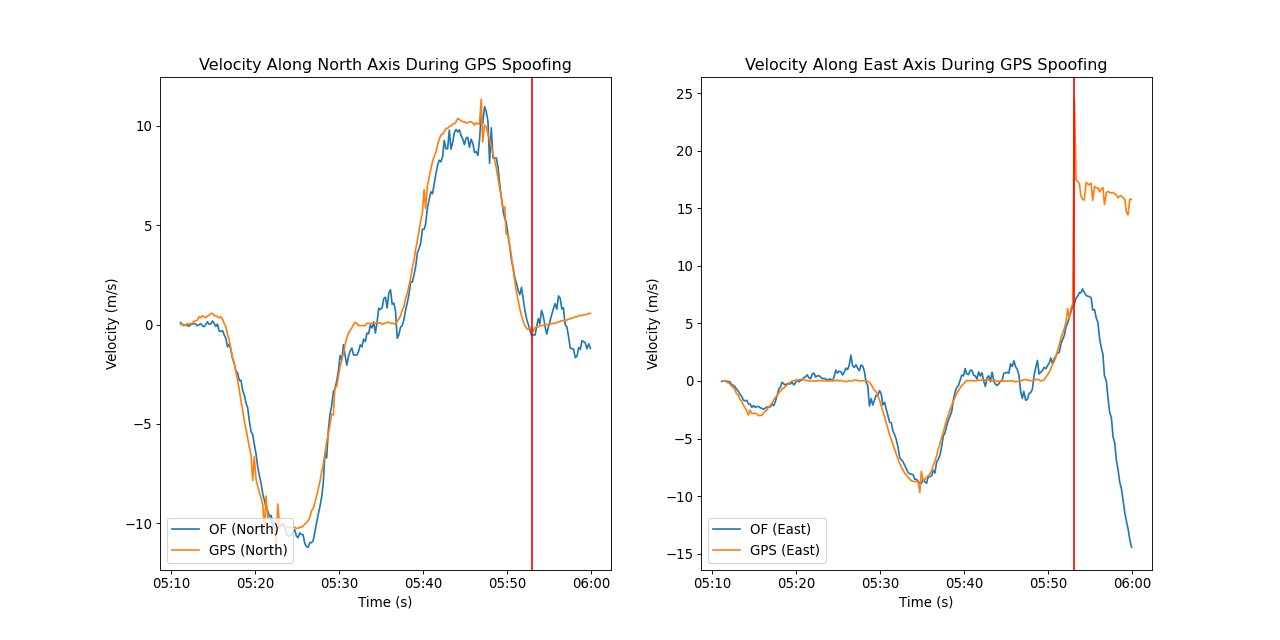

In [15]:
plt.figure(figure, figsize=(16, 8), dpi=80)
figure += 1
ax = plt.subplot(1, 2, 1)
plt1 = plt.plot(gpsMS.gpsMS[:(gpsMS.gpsMS < attack_end).sum()], of_north[:(gpsMS.gpsMS < attack_end).sum()]-of_north[1], label="OF (North)")
plt2 = plt.plot(gpsMS.gpsMS[:(gpsMS.gpsMS < attack_end).sum()], gps_north[:(gpsMS.gpsMS < attack_end).sum()], label="GPS (North)")
plt.axvline(attack_start, color='r')
plt.xlabel("Time (s)")
plt.ylabel("Velocity (m/s)")
plt.title("Velocity Along North Axis During GPS Spoofing")
ax.xaxis.set_major_formatter(dates.DateFormatter('%M:%S'))
plt.legend(loc='lower left')
ax = plt.subplot(1, 2, 2)
plt3 = plt.plot(gpsMS.gpsMS[:(gpsMS.gpsMS < attack_end).sum()], of_east[:(gpsMS.gpsMS < attack_end).sum()]-of_east[1], label="OF (East)")
plt4 = plt.plot(gpsMS.gpsMS[1:(gpsMS.gpsMS < attack_end).sum()], gps_east[1:(gpsMS.gpsMS < attack_end).sum()], label="GPS (East)")
plt.axvline(attack_start, color='r')
plt.xlabel("Time (s)")
plt.ylabel("Velocity (m/s)")
plt.title("Velocity Along East Axis During GPS Spoofing")
ax.xaxis.set_major_formatter(dates.DateFormatter('%M:%S'))
plt.legend(loc='lower left')
plt.show()

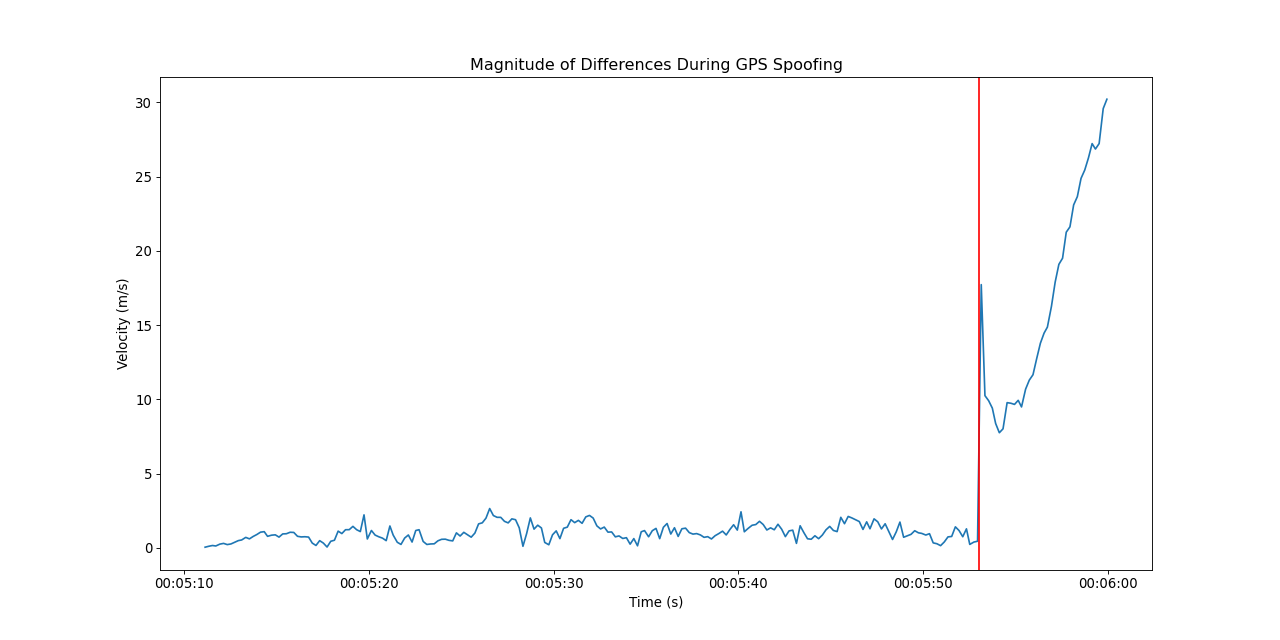

In [16]:
plt.figure(figure, figsize=(16, 8), dpi=80)
figure += 1
diff_east = abs((gps_east - of_east)[:(gpsMS.gpsMS < attack_end).sum()])
diff_north = abs((gps_north - of_north)[:(gpsMS.gpsMS < attack_end).sum()])
diffs = pd.Series([((x**2) + (y**2))**(1/2) for x,y in zip(diff_east, diff_north)])
plt.plot(gpsMS.gpsMS[:(gpsMS.gpsMS < attack_end).sum()],diffs)
plt.axvline(attack_start, color='r')
plt.xlabel("Time (s)")
plt.ylabel("Velocity (m/s)")
plt.title("Magnitude of Differences During GPS Spoofing")
ax.xaxis.set_major_formatter(dates.DateFormatter('%M:%S'))
plt.show()

In [17]:
print("Maxdiffserence between GPS and OF before attack is %f m/s and after attack is %f m/s" % (
       diffs[gpsMS.gpsMS < attack_start].max(),
       diffs[(gpsMS.gpsMS >= attack_start) & (gpsMS.gpsMS < attack_end)].max())
     )

Maxdiffserence between GPS and OF before attack is 2.647668 m/s and after attack is 30.217341 m/s


In [18]:
dt = (gpsMS.gpsMS[diffs[diffs>benign_dist].index[0]] - attack_start).total_seconds()
print("Time until detection: %fs" % dt)

Time until detection: 0.099776s


In [19]:
from confirmation.process import length
OF_Vel_East = of_east[(gpsMS.gpsMS >= attack_start) & (gpsMS.gpsMS < pd.Timestamp((attack_start.value/1000000000) + dt, unit='s'))]
OF_Vel_North = of_north[(gpsMS.gpsMS >= attack_start) & (gpsMS.gpsMS < pd.Timestamp((attack_start.value/1000000000) + dt, unit='s'))]
OF_Vel = length([OF_Vel_East.reset_index(drop=True), OF_Vel_North.reset_index(drop=True)])
OF_ts = gpsMS.gpsMS[(gpsMS.gpsMS >= attack_start) & (gpsMS.gpsMS < pd.Timestamp((attack_start.value/1000000000) + dt, unit='s'))]
print("Distance traveled until detection according to Optical Flow: %fm" % abs(trapezoid(y=OF_Vel, x=OF_ts.diff().dt.total_seconds().fillna(0).cumsum())))

Distance traveled until detection according to Optical Flow: 0.000000m


d:\nextcloud\documents\ku\padlock\code\sensorconfirmation\src\confirmation\process.py:269: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  return(pd.Series(data=res, name=name))


## GPS Ground Course and Gyroscope Yaw

In [20]:
#Read in data
df = pd.read_csv(output)

#All of the data is numeric and should be treated as such
df = df.apply(pd.to_numeric)

#Only want the aprt of the mission where the GPS is actually usable
df = df[df.TimeUS >= 320000000].reset_index(drop=True)

#Set index to be the timestamps so we can drop duplicate rows
#then reset index to be row number
df.set_index("TimeUS",inplace=True)
df = df.drop_duplicates()
df.reset_index(inplace=True)

#Get rid of duplicate rows and convert timestamps to datetime
cUS = df[df.cUS.shift() != df.cUS][["cUS","gyrx","gyry","gyrz","CAN","CAE","CAD","rCAN","rCAE","rCAD", "CVN", "CVE", "CVD"]].reset_index()
cUS['cUS'] = pd.to_datetime(cUS['cUS'], unit='us')
gpsMS = df[df.gpsMS.shift() != df.gpsMS][["gpsMS","lat","lng","gpAlt", "m00", "m10"]].reset_index()
gpsMS['gpsMS'] = pd.to_datetime(gpsMS['gpsMS'], unit='ms')

In [21]:
#GPS Velocity
gps = geodetic2ned(gpsMS.lat, gpsMS.lng, gpsMS.gpAlt)
gps_north = (gps.North.diff().fillna(0)/(gpsMS.gpsMS.diff().dt.total_seconds()))[1:].reset_index(drop=True)
gps_east = (gps.East.diff().fillna(0)/(gpsMS.gpsMS.diff().dt.total_seconds()))[1:].reset_index(drop=True)
gps_down = (gps.Down.diff().fillna(0)/100/(gpsMS.gpsMS.diff().dt.total_seconds()))[1:].reset_index(drop=True)

gps_east = pd.Series(gps_east)
gps_north = pd.Series(gps_north)

#GPS derived ground course
gps_gc = []
for reading in range(len(gps_north)):
    gps_gc.append(degrees(atan2(gps_east[reading], gps_north[reading])) % 360)
gps_gc = pd.Series(gps_gc, name="GPS Ground Course")

#Matching gyroscope to the GPS update rate
gyr_yaw = trap_integrate(cUS.cUS.diff().dt.total_seconds().fillna(0).cumsum(), cUS.gyrz).apply(degrees).cumsum() % 360
gyr_gps_yaw = signal_match_and_cumsum(cUS.cUS.diff().dt.total_seconds().fillna(0).cumsum()[2:].reset_index(drop=True), change_in_signal(gyr_yaw),
                                          gpsMS.gpsMS.diff().dt.total_seconds().fillna(0).cumsum(), gps_gc)
gyr_gps_yaw = pd.Series(gyr_gps_yaw, name="Gyroscope Yaw")

#Start both signals at 0 to align them
gps_gc = (gps_gc - gps_gc[0] + 120) % 360
gyr_gps_yaw = (gyr_gps_yaw - gyr_gps_yaw[0] + 120)%360

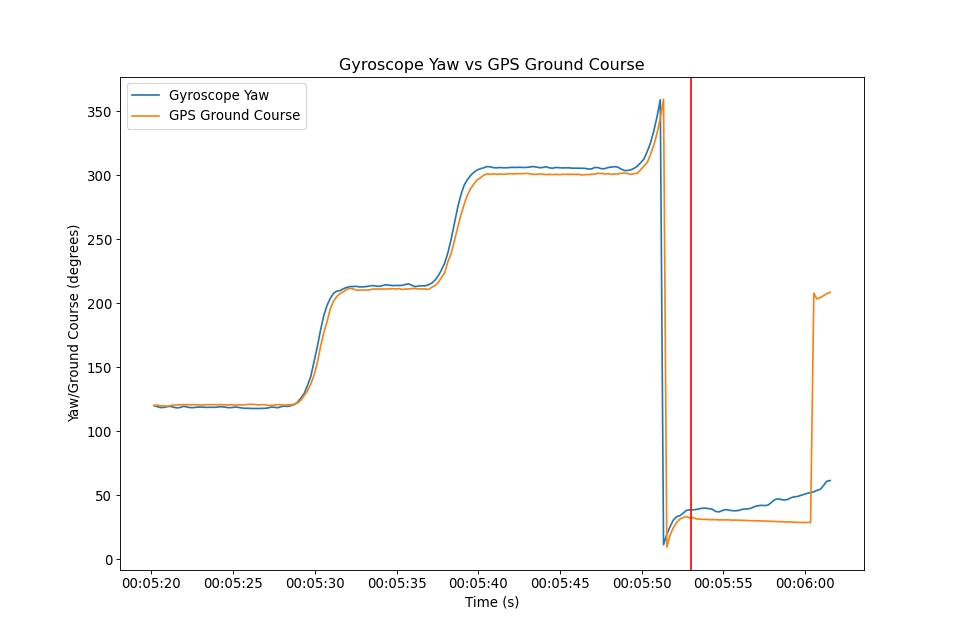

In [22]:
plt.figure(figure, figsize=(12, 8), dpi=80)
figure += 1
plt.subplot(1, 1, 1)
plt.plot(gpsMS.gpsMS[1:], gyr_gps_yaw, label="Gyroscope Yaw")
plt.plot(gpsMS.gpsMS[1:], gps_gc, label="GPS Ground Course")
plt.xlabel("Time (s)")
plt.ylabel("Yaw/Ground Course (degrees)")
plt.title("Gyroscope Yaw vs GPS Ground Course")
ax.xaxis.set_major_formatter(dates.DateFormatter('%M:%S'))
plt.axvline(attack_start, color='r')
plt.legend()
plt.show()

In [23]:
angle_diff = abs(diff(gps_gc[1:].reset_index(drop=True), gyr_gps_yaw, wrap=True))

print("Difference between GPS and OF before attack is %f degrees and after attack is %f degrees" % (
       angle_diff[gpsMS.gpsMS < attack_start].max(),
       angle_diff[(gpsMS.gpsMS >= attack_start) & (gpsMS.gpsMS < attack_end)].max())
     )

Difference between GPS and OF before attack is 7.631150 degrees and after attack is 22.687133 degrees


In [24]:
dt = (gpsMS.gpsMS[angle_diff[angle_diff>benign_angle].index[0]] - attack_start).total_seconds()
print("Time until detection: %fs" % dt)

Time until detection: 4.699776s


## 3rd Flight, 0.1m/s/s, 2.5m offset (Flight Ended before Detection Possible)

In [25]:
#Convert log file from Mission Planner to usable CSV
data_dir = "../data/"
file = "2023-02-01-Adv-250cm-0_1mss (1).log" #Change file for different log files
output = data_dir + "interim/" + file[:-3] + "csv"

#Check if file exists already and if it does skip processing and read the file
if not exists(output):
    #Open log file and parse out the SNS data into pandas dataframes
    df = process_SNS(data_dir + "raw/" + file, output, SNS_COUNT=5)
else:
    df = pd.read_csv(output)

#All of the data is numeric and should be treated as such
df = df.apply(pd.to_numeric)

#Set index to be the timestamps so we can drop duplicate rows
#then reset index to be row number
df.set_index("TimeUS",inplace=True)
df = df.drop_duplicates()
df.reset_index(inplace=True)

#Get rid of duplicate rows and convert timestamps to datetime
ofMS = df[df.ofMS.shift() != df.ofMS][["ofMS","frF","frR","brF","brR", "rf", "m00", "m10"]].reset_index()
ofMS['ofMS'] = pd.to_datetime(ofMS['ofMS'], unit='ms')
magUS = df[df.magUS.shift() != df.magUS][["magUS","magx","magy","magz"]].reset_index()
magUS['magUS'] = pd.to_datetime(magUS['magUS'], unit='us')
cUS = df[df.cUS.shift() != df.cUS][["cUS","gyrx","gyry","gyrz","CAN","CAE","CAD","rCAN","rCAE","rCAD", "CVN", "CVE", "CVD"]].reset_index()
cUS['cUS'] = pd.to_datetime(cUS['cUS'], unit='us')
gpsMS = df[df.gpsMS.shift() != df.gpsMS][["gpsMS","lat","lng","gpAlt", "m00", "m10"]].reset_index()
gpsMS['gpsMS'] = pd.to_datetime(gpsMS['gpsMS'], unit='ms')
rfMS = df[df.rfMS.shift() != df.rfMS][["rfMS","rf","m22"]].reset_index(drop=True)
rfMS['rfMS'] = pd.to_datetime(rfMS['rfMS'], unit='ms')

attack_start = pd.to_datetime(328596249, unit='us')
attack_end = pd.to_datetime(335236417, unit='us')

# Velocity

In [26]:
#GPS Velocity
gps = geodetic2ned(gpsMS.lat, gpsMS.lng, gpsMS.gpAlt)
gps_north = (gps.North.diff().fillna(0)/(gpsMS.gpsMS.diff().dt.total_seconds()))[1:].reset_index(drop=True)
gps_east = (gps.East.diff().fillna(0)/(gpsMS.gpsMS.diff().dt.total_seconds()))[1:].reset_index(drop=True)
gps_down = (gps.Down.diff().fillna(0)/100/(gpsMS.gpsMS.diff().dt.total_seconds()))[1:].reset_index(drop=True)

#Convert optical flow and rangefinder to OF Velocity in body frame
of_vel_bf = pd.DataFrame(data={"OF Forward":(ofMS.frF - ofMS.brF) * ofMS.rf/100,
                               "OF Right":(ofMS.frR - ofMS.brR) * ofMS.rf/100})

earth_frame = body_to_earth2D(of_vel_bf["OF Forward"], of_vel_bf["OF Right"], ofMS.m00, ofMS.m10)

lpf_E = -low_pass_filter(earth_frame.East, alpha=0.2)
lpf_N = low_pass_filter(earth_frame.North, alpha=0.2)

gps_east = pd.Series(gps_east)
lpf_E = pd.Series(lpf_E)
gps_north = pd.Series(gps_north)
lpf_N = pd.Series(lpf_N)

#Matching OF to the GPS update rate
of_east = signal_match_and_cumsum(ofMS.ofMS[:-1].diff().dt.total_seconds().fillna(0).cumsum(), change_in_signal(lpf_E),
                                          gpsMS.gpsMS.diff().dt.total_seconds().fillna(0).cumsum(), gps_east)
of_east = pd.Series(of_east, name="OF East, LPF")
of_north = signal_match_and_cumsum(ofMS.ofMS[:-1].diff().dt.total_seconds().fillna(0).cumsum(), change_in_signal(lpf_N),
                                          gpsMS.gpsMS.diff().dt.total_seconds().fillna(0).cumsum(), gps_north)
of_north = pd.Series(of_north, name="OF North, LPF")

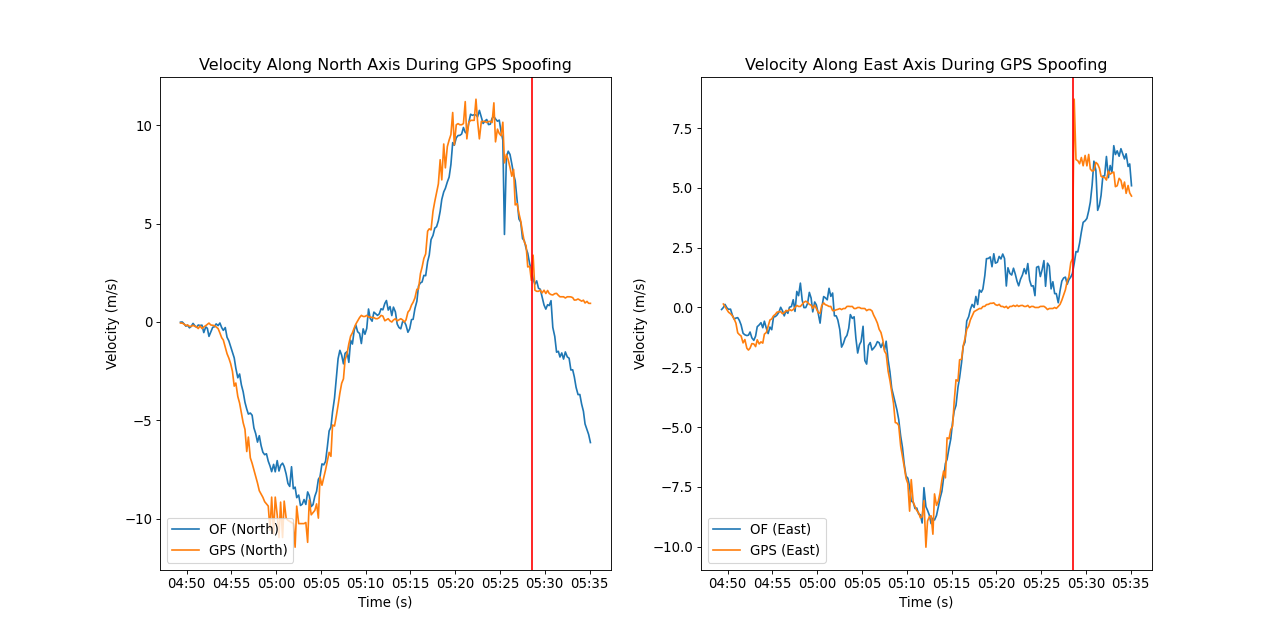

In [27]:
plt.figure(figure, figsize=(16, 8), dpi=80)
figure += 1
ax = plt.subplot(1, 2, 1)
plt1 = plt.plot(gpsMS.gpsMS[:(gpsMS.gpsMS < attack_end).sum()], of_north[:(gpsMS.gpsMS < attack_end).sum()]-of_north[1], label="OF (North)")
plt2 = plt.plot(gpsMS.gpsMS[:(gpsMS.gpsMS < attack_end).sum()], gps_north[:(gpsMS.gpsMS < attack_end).sum()], label="GPS (North)")
plt.axvline(attack_start, color='r')
plt.xlabel("Time (s)")
plt.ylabel("Velocity (m/s)")
plt.title("Velocity Along North Axis During GPS Spoofing")
ax.xaxis.set_major_formatter(dates.DateFormatter('%M:%S'))
plt.legend(loc='lower left')
ax = plt.subplot(1, 2, 2)
plt3 = plt.plot(gpsMS.gpsMS[:(gpsMS.gpsMS < attack_end).sum()], of_east[:(gpsMS.gpsMS < attack_end).sum()]-of_east[1], label="OF (East)")
plt4 = plt.plot(gpsMS.gpsMS[1:(gpsMS.gpsMS < attack_end).sum()], gps_east[1:(gpsMS.gpsMS < attack_end).sum()], label="GPS (East)")
plt.axvline(attack_start, color='r')
plt.xlabel("Time (s)")
plt.ylabel("Velocity (m/s)")
plt.title("Velocity Along East Axis During GPS Spoofing")
ax.xaxis.set_major_formatter(dates.DateFormatter('%M:%S'))
plt.legend(loc='lower left')
plt.show()

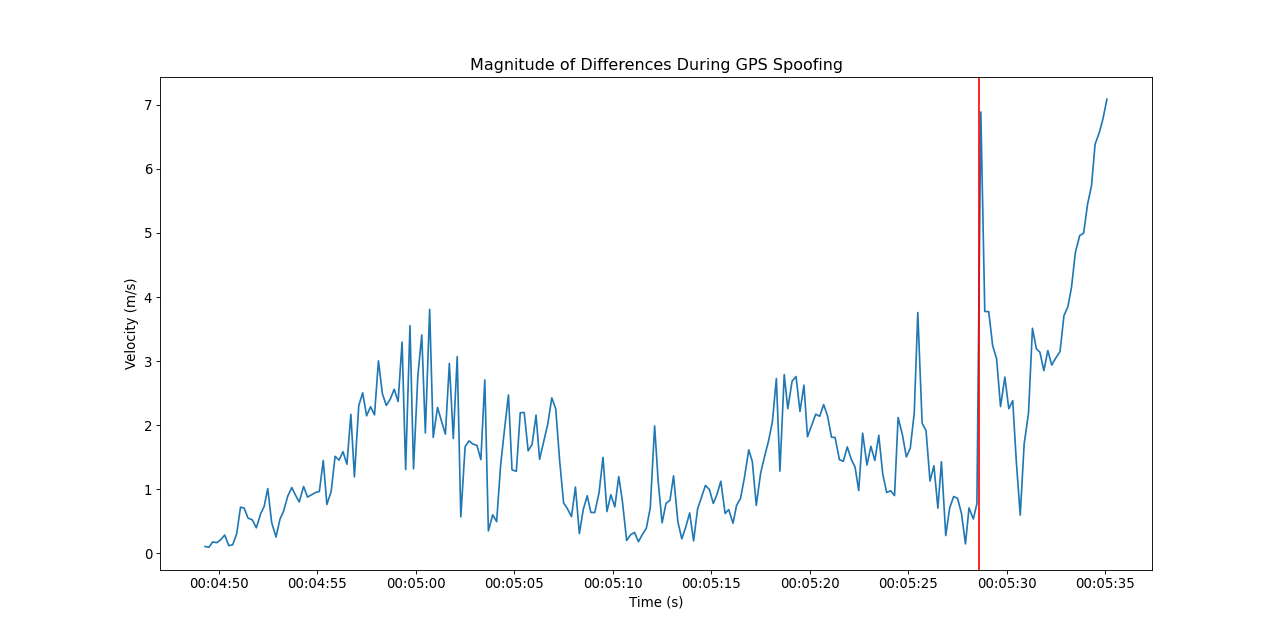

In [28]:
plt.figure(figure, figsize=(16, 8), dpi=80)
figure += 1
diff_east = abs((gps_east - of_east)[:(gpsMS.gpsMS < attack_end).sum()])
diff_north = abs((gps_north - of_north)[:(gpsMS.gpsMS < attack_end).sum()])
diffs = pd.Series([((x**2) + (y**2))**(1/2) for x,y in zip(diff_east, diff_north)])
plt.plot(gpsMS.gpsMS[:(gpsMS.gpsMS < attack_end).sum()],diffs)
plt.axvline(attack_start, color='r')
plt.xlabel("Time (s)")
plt.ylabel("Velocity (m/s)")
plt.title("Magnitude of Differences During GPS Spoofing")
ax.xaxis.set_major_formatter(dates.DateFormatter('%M:%S'))
plt.show()

In [29]:
print("Max difference between GPS and OF before attack is %f m/s and after attack is %f m/s" % (
       diffs[gpsMS.gpsMS < attack_start].max(),
       diffs[(gpsMS.gpsMS >= attack_start) & (gpsMS.gpsMS < attack_end)].max())
     )

Max difference between GPS and OF before attack is 3.807881 m/s and after attack is 7.089403 m/s


In [30]:
try:
    dt = (gpsMS.gpsMS[diffs[diffs>benign_dist].index[0]] - attack_start).total_seconds()
    print("Time until detection: %fs" % dt)
except:
    print("No attack detected")

No attack detected


## GPS Ground Course and Gyroscope Yaw

In [31]:
#Read in data
df = pd.read_csv(output)

#All of the data is numeric and should be treated as such
df = df.apply(pd.to_numeric)

#Only want the aprt of the mission where the GPS is actually usable
df = df[df.TimeUS >= 292000000].reset_index(drop=True)

#Set index to be the timestamps so we can drop duplicate rows
#then reset index to be row number
df.set_index("TimeUS",inplace=True)
df = df.drop_duplicates()
df.reset_index(inplace=True)

#Get rid of duplicate rows and convert timestamps to datetime
cUS = df[df.cUS.shift() != df.cUS][["cUS","gyrx","gyry","gyrz","CAN","CAE","CAD","rCAN","rCAE","rCAD", "CVN", "CVE", "CVD"]].reset_index()
cUS['cUS'] = pd.to_datetime(cUS['cUS'], unit='us')
gpsMS = df[df.gpsMS.shift() != df.gpsMS][["gpsMS","lat","lng","gpAlt", "m00", "m10"]].reset_index()
gpsMS['gpsMS'] = pd.to_datetime(gpsMS['gpsMS'], unit='ms')

In [32]:
#GPS Velocity
gps = geodetic2ned(gpsMS.lat, gpsMS.lng, gpsMS.gpAlt)
gps_north = (gps.North.diff().fillna(0)/(gpsMS.gpsMS.diff().dt.total_seconds()))[1:].reset_index(drop=True)
gps_east = (gps.East.diff().fillna(0)/(gpsMS.gpsMS.diff().dt.total_seconds()))[1:].reset_index(drop=True)
gps_down = (gps.Down.diff().fillna(0)/100/(gpsMS.gpsMS.diff().dt.total_seconds()))[1:].reset_index(drop=True)

gps_east = pd.Series(gps_east)
gps_north = pd.Series(gps_north)

#GPS derived ground course
gps_gc = []
for reading in range(len(gps_north)):
    gps_gc.append(degrees(atan2(gps_east[reading], gps_north[reading])) % 360)
gps_gc = pd.Series(gps_gc, name="GPS Ground Course")

#Matching gyroscope to the GPS update rate
gyr_yaw = trap_integrate(cUS.cUS.diff().dt.total_seconds().fillna(0).cumsum(), cUS.gyrz).apply(degrees).cumsum() % 360
gyr_gps_yaw = signal_match_and_cumsum(cUS.cUS.diff().dt.total_seconds().fillna(0).cumsum(), change_in_signal(gyr_yaw),
                                          gpsMS.gpsMS.diff().dt.total_seconds().fillna(0).cumsum(), gps_gc)
gyr_gps_yaw = pd.Series(gyr_gps_yaw, name="Gyroscope Yaw")

#Start both signals at 0 to align them
gps_gc = (gps_gc - gps_gc[0] + 90) % 360
gyr_gps_yaw = (gyr_gps_yaw - gyr_gps_yaw[0] + 90)%360

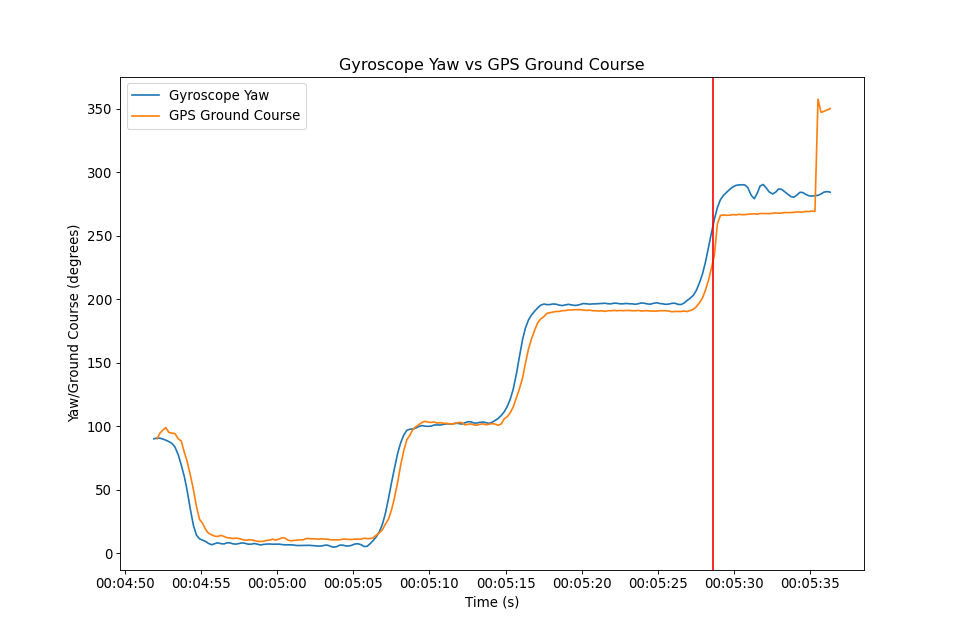

In [33]:
plt.figure(figure, figsize=(12, 8), dpi=80)
figure += 1
plt.subplot(1, 1, 1)
plt.plot(gpsMS.gpsMS, gyr_gps_yaw, label="Gyroscope Yaw")
plt.plot(gpsMS.gpsMS[1:], gps_gc, label="GPS Ground Course")
plt.xlabel("Time (s)")
plt.ylabel("Yaw/Ground Course (degrees)")
plt.title("Gyroscope Yaw vs GPS Ground Course")
ax.xaxis.set_major_formatter(dates.DateFormatter('%M:%S'))
plt.axvline(attack_start, color='r')
plt.legend()
plt.show()

In [34]:
angle_diff = abs(diff(gps_gc[1:].reset_index(drop=True), gyr_gps_yaw, wrap=True))

print("Difference between GPS and OF before attack is %f degrees and after attack is %f degrees" % (
       angle_diff[gpsMS.gpsMS < attack_start].max(),
       angle_diff[(gpsMS.gpsMS >= attack_start) & (gpsMS.gpsMS < attack_end)].max())
     )

Difference between GPS and OF before attack is 9.358215 degrees and after attack is 76.370588 degrees


In [35]:
dt = (gpsMS.gpsMS[angle_diff[angle_diff>benign_angle].index[0]] - attack_start).total_seconds()
print("Time until detection: %fs" % dt)

Time until detection: 0.699751s


## 4th Flight, 0.1m/s/s, 2.5m offset (1 False Positive in Velocity and 2 in Ground Course)

In [36]:
#Convert log file from Mission Planner to usable CSV
data_dir = "../data/"
file = "2023-02-01-Adv-250cm-0_1mss (2).log" #Change file for different log files
output = data_dir + "interim/" + file[:-3] + "csv"

#Check if file exists already and if it does skip processing and read the file
if not exists(output):
    #Open log file and parse out the SNS data into pandas dataframes
    df = process_SNS(data_dir + "raw/" + file, output, SNS_COUNT=5)
else:
    df = pd.read_csv(output)

#All of the data is numeric and should be treated as such
df = df.apply(pd.to_numeric)

#Set index to be the timestamps so we can drop duplicate rows
#then reset index to be row number
df.set_index("TimeUS",inplace=True)
df = df.drop_duplicates()
df.reset_index(inplace=True)

#Get rid of duplicate rows and convert timestamps to datetime
ofMS = df[df.ofMS.shift() != df.ofMS][["ofMS","frF","frR","brF","brR", "rf", "m00", "m10"]].reset_index()
ofMS['ofMS'] = pd.to_datetime(ofMS['ofMS'], unit='ms')
magUS = df[df.magUS.shift() != df.magUS][["magUS","magx","magy","magz"]].reset_index()
magUS['magUS'] = pd.to_datetime(magUS['magUS'], unit='us')
cUS = df[df.cUS.shift() != df.cUS][["cUS","gyrx","gyry","gyrz","CAN","CAE","CAD","rCAN","rCAE","rCAD", "CVN", "CVE", "CVD"]].reset_index()
cUS['cUS'] = pd.to_datetime(cUS['cUS'], unit='us')
gpsMS = df[df.gpsMS.shift() != df.gpsMS][["gpsMS","lat","lng","gpAlt", "m00", "m10"]].reset_index()
gpsMS['gpsMS'] = pd.to_datetime(gpsMS['gpsMS'], unit='ms')
rfMS = df[df.rfMS.shift() != df.rfMS][["rfMS","rf","m22"]].reset_index(drop=True)
rfMS['rfMS'] = pd.to_datetime(rfMS['rfMS'], unit='ms')

attack_start = pd.to_datetime(413945026, unit='us')
attack_end = pd.to_datetime(421837977, unit='us')

# Velocity

In [37]:
#GPS Velocity
gps = geodetic2ned(gpsMS.lat, gpsMS.lng, gpsMS.gpAlt)
gps_north = (gps.North.diff().fillna(0)/(gpsMS.gpsMS.diff().dt.total_seconds()))[1:].reset_index(drop=True)
gps_east = (gps.East.diff().fillna(0)/(gpsMS.gpsMS.diff().dt.total_seconds()))[1:].reset_index(drop=True)
gps_down = (gps.Down.diff().fillna(0)/100/(gpsMS.gpsMS.diff().dt.total_seconds()))[1:].reset_index(drop=True)

#Convert optical flow and rangefinder to OF Velocity in body frame
of_vel_bf = pd.DataFrame(data={"OF Forward":(ofMS.frF - ofMS.brF) * ofMS.rf/100,
                               "OF Right":(ofMS.frR - ofMS.brR) * ofMS.rf/100})

earth_frame = body_to_earth2D(of_vel_bf["OF Forward"], of_vel_bf["OF Right"], ofMS.m00, ofMS.m10)

lpf_E = -low_pass_filter(earth_frame.East, alpha=0.2)
lpf_N = low_pass_filter(earth_frame.North, alpha=0.2)

gps_east = pd.Series(gps_east)
lpf_E = pd.Series(lpf_E)
gps_north = pd.Series(gps_north)
lpf_N = pd.Series(lpf_N)

#Matching OF to the GPS update rate
of_east = signal_match_and_cumsum(ofMS.ofMS[:-1].diff().dt.total_seconds().fillna(0).cumsum(), change_in_signal(lpf_E),
                                          gpsMS.gpsMS.diff().dt.total_seconds().fillna(0).cumsum(), gps_east)
of_east = pd.Series(of_east, name="OF East, LPF")
of_north = signal_match_and_cumsum(ofMS.ofMS[:-1].diff().dt.total_seconds().fillna(0).cumsum(), change_in_signal(lpf_N),
                                          gpsMS.gpsMS.diff().dt.total_seconds().fillna(0).cumsum(), gps_north)
of_north = pd.Series(of_north, name="OF North, LPF")

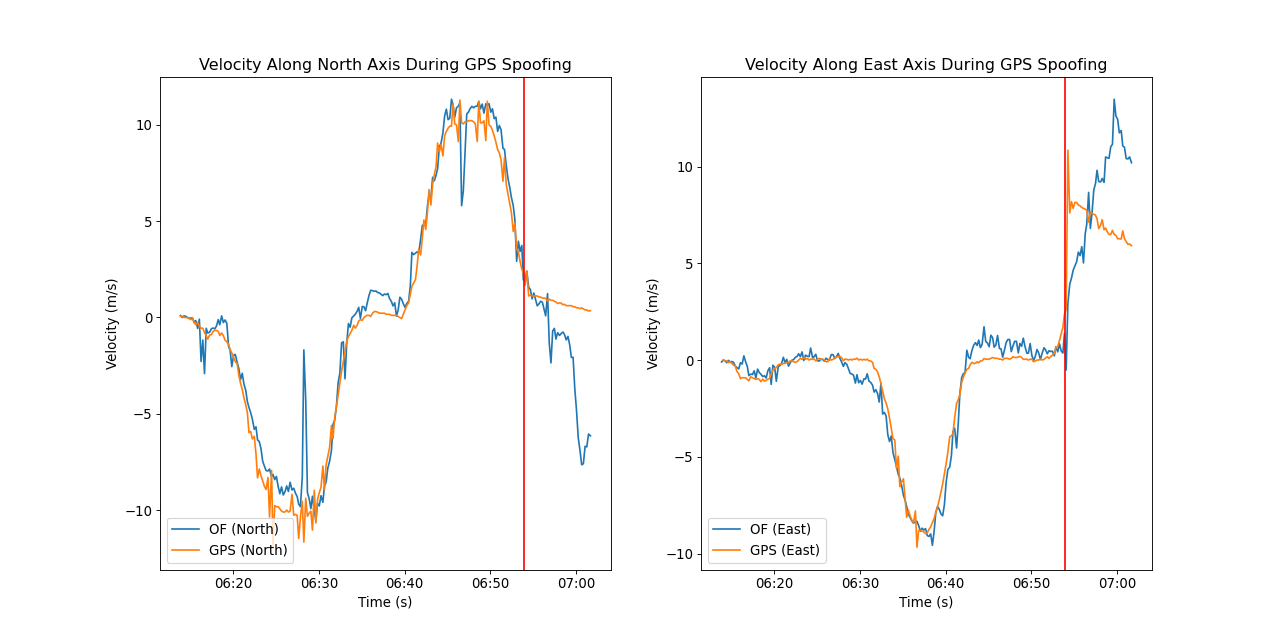

In [38]:
plt.figure(figure, figsize=(16, 8), dpi=80)
figure += 1
ax = plt.subplot(1, 2, 1)
plt1 = plt.plot(gpsMS.gpsMS[:(gpsMS.gpsMS < attack_end).sum()][1:], of_north[:(gpsMS.gpsMS < attack_end).sum()]-of_north[1], label="OF (North)")
plt2 = plt.plot(gpsMS.gpsMS[:(gpsMS.gpsMS < attack_end).sum()][1:], gps_north[:(gpsMS.gpsMS < attack_end).sum()], label="GPS (North)")
plt.axvline(attack_start, color='r')
plt.xlabel("Time (s)")
plt.ylabel("Velocity (m/s)")
plt.title("Velocity Along North Axis During GPS Spoofing")
ax.xaxis.set_major_formatter(dates.DateFormatter('%M:%S'))
plt.legend(loc='lower left')
ax = plt.subplot(1, 2, 2)
plt3 = plt.plot(gpsMS.gpsMS[:(gpsMS.gpsMS < attack_end).sum()][1:], of_east[:(gpsMS.gpsMS < attack_end).sum()]-of_east[1], label="OF (East)")
plt4 = plt.plot(gpsMS.gpsMS[1:(gpsMS.gpsMS < attack_end).sum()][1:], gps_east[1:(gpsMS.gpsMS < attack_end).sum()], label="GPS (East)")
plt.axvline(attack_start, color='r')
plt.xlabel("Time (s)")
plt.ylabel("Velocity (m/s)")
plt.title("Velocity Along East Axis During GPS Spoofing")
ax.xaxis.set_major_formatter(dates.DateFormatter('%M:%S'))
plt.legend(loc='lower left')
plt.show()

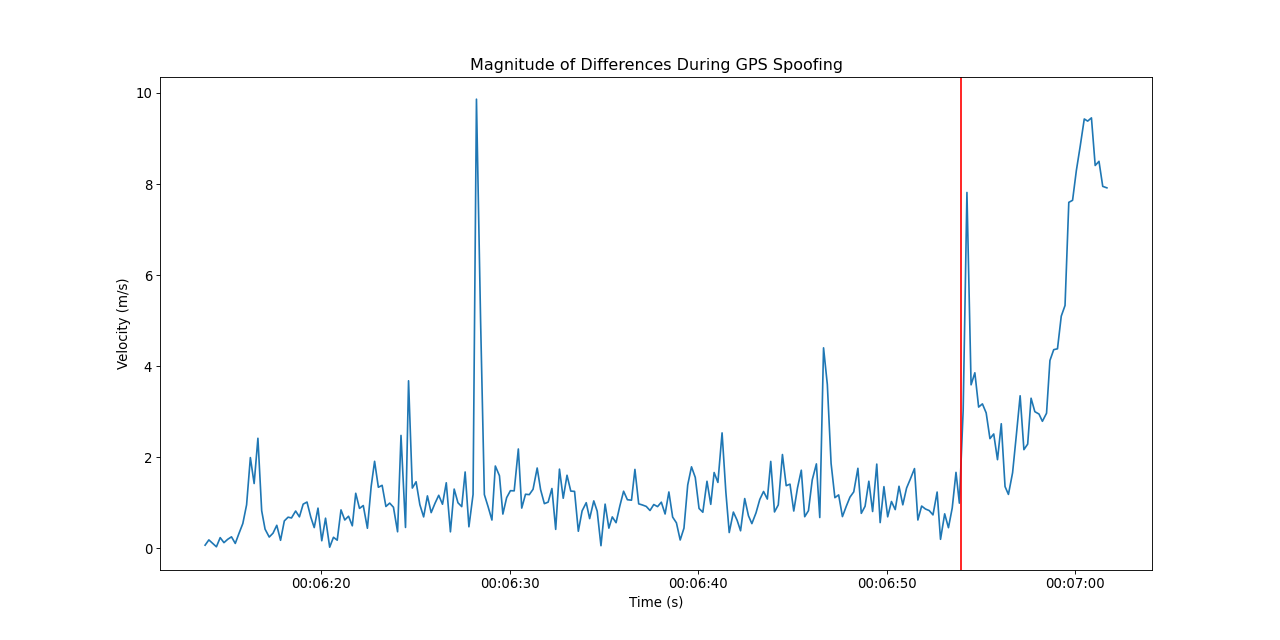

In [39]:
plt.figure(figure, figsize=(16, 8), dpi=80)
figure += 1
diff_east = abs((gps_east - of_east)[:(gpsMS.gpsMS < attack_end).sum()])
diff_north = abs((gps_north - of_north)[:(gpsMS.gpsMS < attack_end).sum()])
diffs = pd.Series([((x**2) + (y**2))**(1/2) for x,y in zip(diff_east, diff_north)])
plt.plot(gpsMS.gpsMS[:(gpsMS.gpsMS < attack_end).sum()][1:],diffs)
plt.axvline(attack_start, color='r')
plt.xlabel("Time (s)")
plt.ylabel("Velocity (m/s)")
plt.title("Magnitude of Differences During GPS Spoofing")
ax.xaxis.set_major_formatter(dates.DateFormatter('%M:%S'))
plt.show()

In [40]:
print("Difference between GPS and OF before attack is %f m/s and after attack is %f m/s" % (
       diffs[gpsMS.gpsMS < attack_start].max(),
       diffs[(gpsMS.gpsMS >= attack_start) & (gpsMS.gpsMS < attack_end)].max())
     )

Difference between GPS and OF before attack is 9.862348 m/s and after attack is 9.452355 m/s


In [41]:
dt = (gpsMS.gpsMS[diffs[diffs>benign_dist].index[2]] - attack_start).total_seconds()
print("Time until detection: %fs" % dt)

Time until detection: 5.499974s


In [42]:
from confirmation.process import length
OF_Vel_East = of_east[(gpsMS.gpsMS >= attack_start) & (gpsMS.gpsMS < pd.Timestamp((attack_start.value/1000000000) + dt, unit='s'))]
OF_Vel_North = of_north[(gpsMS.gpsMS >= attack_start) & (gpsMS.gpsMS < pd.Timestamp((attack_start.value/1000000000) + dt, unit='s'))]
OF_Vel = length([OF_Vel_East.reset_index(drop=True), OF_Vel_North.reset_index(drop=True)])
OF_ts = gpsMS.gpsMS[(gpsMS.gpsMS >= attack_start) & (gpsMS.gpsMS < pd.Timestamp((attack_start.value/1000000000) + dt, unit='s'))]
print("Distance traveled until detection according to Optical Flow: %fm" % abs(trapezoid(y=OF_Vel, x=OF_ts.diff().dt.total_seconds().fillna(0).cumsum())))

Distance traveled until detection according to Optical Flow: 40.000059m


## GPS Ground Course and Gyroscope Yaw

In [43]:
#Read in data
df = pd.read_csv(output)

#All of the data is numeric and should be treated as such
df = df.apply(pd.to_numeric)

#Only want the aprt of the mission where the GPS is actually usable
df = df[df.TimeUS >= 377000000]

#Set index to be the timestamps so we can drop duplicate rows
#then reset index to be row number
df.set_index("TimeUS",inplace=True)
df = df.drop_duplicates()
df.reset_index(inplace=True)

#Get rid of duplicate rows and convert timestamps to datetime
cUS = df[df.cUS.shift() != df.cUS][["cUS","gyrx","gyry","gyrz","CAN","CAE","CAD","rCAN","rCAE","rCAD", "CVN", "CVE", "CVD"]].reset_index()
cUS['cUS'] = pd.to_datetime(cUS['cUS'], unit='us')
gpsMS = df[df.gpsMS.shift() != df.gpsMS][["gpsMS","lat","lng","gpAlt", "m00", "m10"]].reset_index()
gpsMS['gpsMS'] = pd.to_datetime(gpsMS['gpsMS'], unit='ms')

In [44]:
#GPS Velocity
gps = geodetic2ned(gpsMS.lat, gpsMS.lng, gpsMS.gpAlt)
gps_north = (gps.North.diff().fillna(0)/(gpsMS.gpsMS.diff().dt.total_seconds()))[1:].reset_index(drop=True)
gps_east = (gps.East.diff().fillna(0)/(gpsMS.gpsMS.diff().dt.total_seconds()))[1:].reset_index(drop=True)
gps_down = (gps.Down.diff().fillna(0)/100/(gpsMS.gpsMS.diff().dt.total_seconds()))[1:].reset_index(drop=True)

gps_east = pd.Series(gps_east)
gps_north = pd.Series(gps_north)

#GPS derived ground course
gps_gc = []
for reading in range(len(gps_north)):
    gps_gc.append(degrees(atan2(gps_east[reading], gps_north[reading])) % 360)
gps_gc = pd.Series(gps_gc, name="GPS Ground Course")

#Matching gyroscope to the GPS update rate
gyr_yaw = trap_integrate(cUS.cUS.diff().dt.total_seconds().fillna(0).cumsum(), cUS.gyrz).apply(degrees).cumsum() % 360
gyr_gps_yaw = signal_match_and_cumsum(cUS.cUS.diff().dt.total_seconds().fillna(0).cumsum()[2:].reset_index(drop=True), change_in_signal(gyr_yaw),
                                          gpsMS.gpsMS.diff().dt.total_seconds().fillna(0).cumsum(), gps_gc)
gyr_gps_yaw = pd.Series(gyr_gps_yaw, name="Gyroscope Yaw")

#Start both signals at 0 to align them
gps_gc = (gps_gc - gps_gc[0] + 90) % 360
gyr_gps_yaw = (gyr_gps_yaw - gyr_gps_yaw[0] + 90)%360

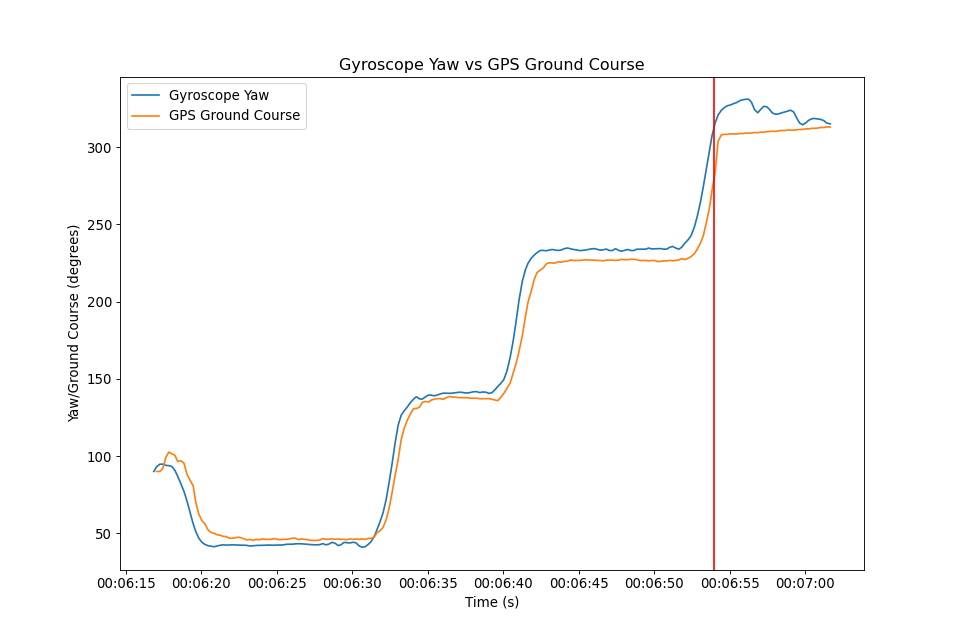

In [45]:
plt.figure(figure, figsize=(12, 8), dpi=80)
figure += 1
plt.subplot(1, 1, 1)
plt.plot(gpsMS.gpsMS, gyr_gps_yaw, label="Gyroscope Yaw")
plt.plot(gpsMS.gpsMS[1:], gps_gc, label="GPS Ground Course")
plt.xlabel("Time (s)")
plt.ylabel("Yaw/Ground Course (degrees)")
plt.title("Gyroscope Yaw vs GPS Ground Course")
ax.xaxis.set_major_formatter(dates.DateFormatter('%M:%S'))
plt.axvline(attack_start, color='r')
plt.legend()
plt.show()

In [46]:
angle_diff = abs(diff(gps_gc[1:].reset_index(drop=True), gyr_gps_yaw, wrap=True))

print("Difference between GPS and OF before attack is %f degrees and after attack is %f degrees" % (
       angle_diff[gpsMS.gpsMS < attack_start].max(),
       angle_diff[(gpsMS.gpsMS >= attack_start) & (gpsMS.gpsMS < attack_end)].max())
     )

Difference between GPS and OF before attack is 14.167539 degrees and after attack is 21.855259 degrees


In [47]:
dt = (gpsMS.gpsMS[angle_diff[angle_diff>benign_angle].index[2]] - attack_start).total_seconds()
print("Time until detection: %fs" % dt)

Time until detection: 0.519974s
